**F23 MATH 596 Final Project Code**

# Imports

In [13]:
import csv
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict
import matplotlib.pyplot as plt
from skimage import io
import pywt
from sklearn import preprocessing

import credit_card_fraud as ccf

import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import (
    shapiro,
    anderson,
    probplot,
    skew,
    chi2_contingency,
    mannwhitneyu,)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

from collections import Counter
import time
import concurrent.futures

%matplotlib inline

# Grabbing Data

In [6]:
df = pd.read_csv("/Users/brand/PycharmProjects/F23-MATH596-FinalProjectCode/creditcard_2023.csv")
df.drop(['id'], axis=1, inplace = True)
target=['Class']

# Data Analysis - Histogram of Amount

Why we drop Amount


In [7]:
fraud = df[df['Class'] == 1]
notFraud = df[df['Class'] == 0]

AttributeError: 'str' object has no attribute 'items'

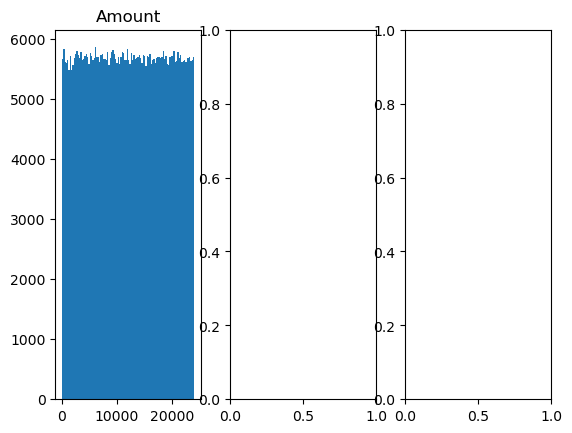

In [14]:
ccf.compare_hist(df, 'Amount','Class')

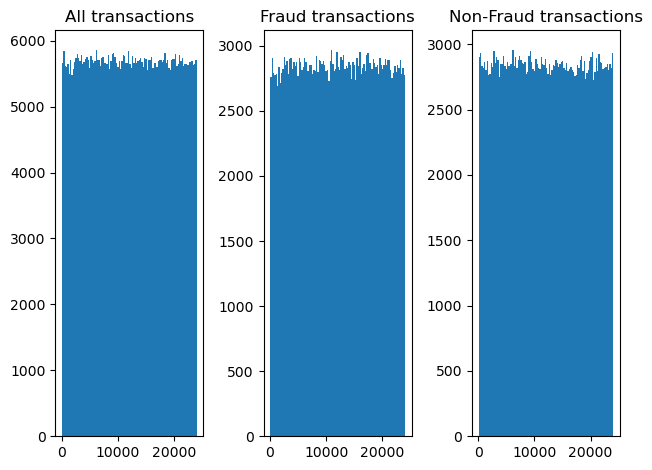

In [8]:
fig, axes = plt.subplots(1, 3)
ax = axes.ravel()
ax[0].hist(df['Amount'], bins = 100)
ax[0].set_title("All transactions")
ax[1].hist(fraud['Amount'], bins = 100)
ax[1].set_title("Fraud transactions")
ax[2].hist(notFraud['Amount'], bins = 100)
ax[2].set_title("Non-Fraud transactions")

plt.tight_layout()

Clearly there is not decernable information we can learn from Amount, so we can drop Amount

In [75]:
df.drop(['Amount'], axis=1, inplace = True)

# Data Analysis - PCA

Why we drop V8, V13, V15, V20 V21, V22, V23, V24, V25, V26, V27, and V28

In [76]:
feature_names = [
    name
    for name in df.columns
    if name not in target
]

In [77]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the data
X_scaled = pd.DataFrame(
    scaler.fit_transform(df[feature_names]),
    columns=feature_names
)

# Perform preliminary PCA
pca = PCA()
X_pca = pd.DataFrame(
    pca.fit_transform(X_scaled),
    columns=[f'PC{i + 1}' for i in range(X_scaled.shape[1])]
)

# Choose number of components based on eigenvalues threshold of 1
num_components = np.argmax(pca.explained_variance_ < 1)
assert num_components > 0, 'Number of components must be > 0'

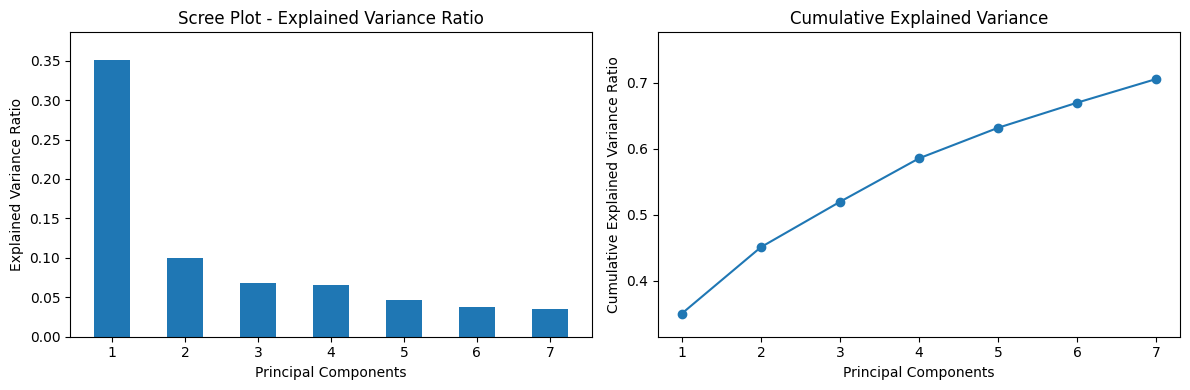

[0.35081875 0.1003474  0.06855385 0.06573291 0.04618497 0.03797056
 0.03575457 0.03106438 0.02935217 0.0269039  0.02207807 0.01977651
 0.01801637 0.0176947  0.01466841 0.01391057 0.01277823 0.01263194
 0.01023187 0.01007227 0.00883764 0.00844629 0.00771313 0.00699824
 0.00680067 0.00651765 0.00622777 0.00391623]


In [78]:
# Visualize scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

# Explained Variance Ratio for Each Principal Component
ax1.bar(
    x=range(1, len(pca.explained_variance_ratio_[:num_components]) + 1),
    height=pca.explained_variance_ratio_[:num_components],
    width=0.5,
)
# Set axes properties
ax1.set_ylim(0.0, pca.explained_variance_ratio_[0] * 1.1)
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot - Explained Variance Ratio')

# Cumulative explained variance ratio plot
ax2.plot(
    range(1, len(pca.explained_variance_ratio_[:num_components]) + 1),
    np.cumsum(pca.explained_variance_ratio_[:num_components]),
    'o-'
)
# Set axes properties
ax2.set_ylim(
    bottom=pca.explained_variance_ratio_[0] * 0.9,
    top=np.cumsum(pca.explained_variance_ratio_[:num_components])[-1] * 1.1
)
ax2.set_xlabel('Principal Components')
ax2.set_ylabel('Cumulative Explained Variance Ratio')
ax2.set_title('Cumulative Explained Variance')

# Display the plots
plt.show()
print(pca.explained_variance_ratio_)

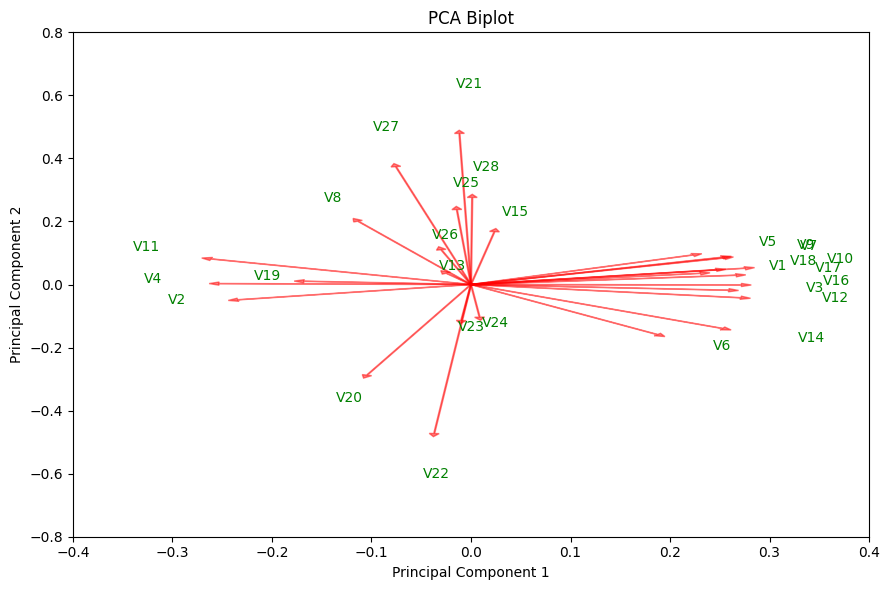

In [79]:
# Visualize PCA biplot
fig, ax1 = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)

# Iterate over features to plot arrows and labels on the biplot
for i, feature in enumerate(feature_names):
    # Plot arrows representing feature contributions to PC1 and PC2
    ax1.arrow(
        x=0,
        y=0,
        dx=pca.components_[0, i],
        dy=pca.components_[1, i],
        color='r',
        alpha=0.5,
        head_width=0.01,
        head_length=0.01,
    )
    # Annotate each arrow with the corresponding feature name
    ax1.text(
        pca.components_[0, i] * 1.3,
        pca.components_[1, i] * 1.3,
        feature,
        color='g'
    )
# Set axes properties
ax1.set_xlim(-0.4, 0.4)
ax1.set_ylim(-0.8, 0.8)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('PCA Biplot')

# Display the biplot
plt.show()

<ipython-input-80-30a96a9bd4e8>:7: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.scatterplot(


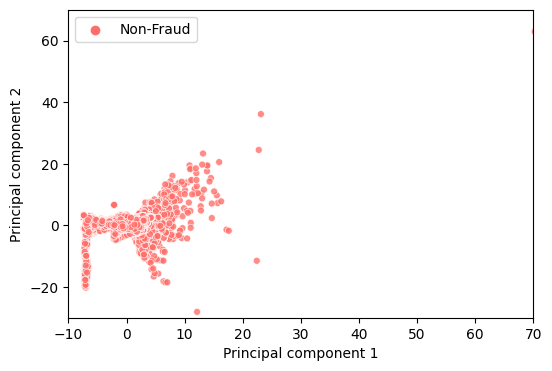

In [80]:
# Plot scatter plot of transactions projected to the first two principal components

# Handle plot layout
fig = plt.figure(figsize=(6, 4))

# Create a scatter plot using Seaborn
ax = sns.scatterplot(
    data=X_pca,
    x='PC1',
    y='PC2',
    hue=df['Class'] \
        .apply(lambda x: 'Fraud' if x == '1' else 'Non-Fraud') \
        .reset_index(drop=True),
    palette=['#FF6F69', '#608654'],
    edgecolor='w',
    linewidth=0.50,
    s=25,
    alpha=0.8,
)

# Set labels for axes
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_xlim(-10, 70)
ax.set_ylim(-30, 70)

# Add a legend
ax.legend(title='', loc='upper left')

# Display the plot
plt.show()

In [81]:
V = df[['V1','V2','V3','V4','V5','V6','V7','V9','V10','V11','V12','V14','V16','V17','V18','V19']]
y = df['Class']

# Modeling
How we constructed our model starting with linear Regression to our final LASSO model

In [82]:
# Base linear regression model
acc = []
for i in range(10):
  V_train, V_test, y_train, y_test = train_test_split(V, y, test_size=0.2)
  res = LinearRegression().fit(V_train, y_train)

  predictions = res.predict(V_test)
  predictions = (predictions >= 0.5).astype(int)

  cnt = np.sum(predictions == y_test)
  acc.append(cnt/len(predictions))

print("Mean Linear Regression Model accuracy:", (round(np.mean(acc), 3))*100,'%')


Mean Linear Regression Model accuracy: 94.69999999999999 %


In [83]:
# Finding largest lamda for sparse LASSO regression model
alph = 0.1
acc = 1
while acc >= 0.90 and alph < 10:
  V_train, V_test, y_train, y_test = train_test_split(V, y, test_size=0.2)
  alph += 0.1
  res = Lasso(alpha=alph).fit(V_train, y_train)

  predictions = res.predict(V_test)
  predictions = (predictions >= 0.5).astype(int)

  cnt = np.sum(predictions == y_test)

  acc2 = cnt/(len(y_test))
  if acc2 < 0.90:
    alph -= 0.1
    break
  else:
    acc = acc2

print("Accuracy:", round(acc, 3)*100,'%')
print("Lamda:", alph)


Accuracy: 93.2 %
Lamda: 0.4


In [84]:
# Finding average LASSO regression model accuracy
acc = []
for i in range(10):
  V_train, V_test, y_train, y_test = train_test_split(V, y, test_size=0.2)
  res =Lasso(alph).fit(V_train, y_train)

  predictions = res.predict(V_test)
  predictions = (predictions >= 0.5).astype(int)

  cnt = np.sum(predictions == y_test)
  acc.append(cnt/len(predictions))

print("Mean LASSO Regression Model accuracy with lamda",alph,':', (round(np.mean(acc), 3))*100,'%')


Mean LASSO Regression Model accuracy with lamda 0.4 : 93.0 %


In [85]:
# Finding True/False Positive/Negative
tpr = []
tnr = []
fpr = []
fnr = []

for i in range(100):
  V_train, V_test, y_train, y_test = train_test_split(V, y, test_size=0.2)
  res = Lasso(alpha=0.4).fit(V_train, y_train)
#  res = LinearRegression().fit(V_train, y_train)

  predictions = res.predict(V_test)
  predictions = (predictions >= 0.5).astype(int)

  zeros = np.zeros(len(predictions))
  ones = zeros + 1

  p = np.sum(predictions == ones)
  n = np.sum(predictions == zeros)
  tp = np.sum((predictions == ones) & (predictions == y_test))
  tn = np.sum((predictions == zeros) & (predictions == y_test))
  fp = p - tp
  fn = n - tn

  tpr.append(tp/(tp+fn))
  tnr.append(tn/(tn+fp))
  fpr.append(fp/(fp+tn))
  fnr.append(fn/(fn+tp))

print("True positive rate:", round(np.mean(tpr), 3)*100,'%')
print("True negative rate:", round(np.mean(tnr), 3)*100,'%')
print("False positive rate:", round(np.mean(fpr), 3)*100,'%')
print("False negative rate:", round(np.mean(fnr), 3)*100,'%')

True positive rate: 88.9 %
True negative rate: 97.0 %
False positive rate: 3.0 %
False negative rate: 11.1 %
